In [ ]:
#!pip install plotly --upgrade --user --quiet
#!pip install pandas --upgrade --user --quiet
#!pip install numpy --upgrade --user --quiet
#!pip install scipy --upgrade --user --quiet
#!pip install statsmodels --upgrade --user --quiet
#!pip install scikit-learn --upgrade --user --quiet
#!pip install missingno --upgrade --user --quiet
#!pip install apafib --upgrade  --quiet

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from time import time
from datetime import timedelta
init_time = time()


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.__version__
from pandas.plotting import scatter_matrix
import missingno as msno


from sklearn import set_config

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets

import warnings

from mpl_toolkits.mplot3d import Axes3D

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

sns.set()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)

set_config(display='text')
warnings.filterwarnings('ignore')

# Credit Card Customers

Los humanos somos impredecibles en general, pero a través de la conducta y las observaciones podemos predecir un poco como actuaremos en el futuro. Esto es un gran recurso a explorar para las empresas que ofrecen servicios, pues les ineresa al máximo conocer y entender como los usuarios estan interactuando con su servicio para mejorarlo y mantenerse competitivos y relevantes.

En este marco se encuentra nuestro proyecto el cual hace uso de un dataset de kaggle llamado Credit Card customers. El cual como su propio nombre indica contiene informacion relacionada con los clienes de un banco teniendo múltiples valores relacionados con su actividad en el mismo y el uso de sus trajetas de crédito.

Todo esto sera utilizado para predecir nuestra variable objetivo "Attrition_Flag" la cual nos indica si el usuario ha cerrado su tarjeta o no. Por lo tanto estamos frente a un problema de clasificación donde hemos de clasificar a los usuarios según si creemos que estos van a cancelar o no su cuenta de forma inminente.

Esto es bastante interesante a nivel empresarial puesto que a estas personas potencialmente descontentas o con ideas de nuevos proyectos en otro lugar necesitan una atención especial por parte de la empresa como medida disuasoria.

##Importamos el dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

#cargamos los datos de los clientes del banco
bank_data = pd.read_csv('BankChurners.csv', delimiter=';')


#hacemos un head para ver un poco como es el formato de la tabla inicialmente
bank_data.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Podemos observar que tenemos 21 variables de las cuales 6 son categoricas, 1 identificativa y 14 númericas. Todas ellas giran entorno a distintos aspectos de interacción entre usuarios y su banco.

Los principales retos a partir del preprocessing son la presencia de unas variables categoricas con ciertos missing values, los cuales deberan ser estudiados. También deberiamos mirar de codificar ciertos valores categoricos como númericos si es necesario para próximos pasos del estudio.

##Eliminamos valores innecesarios

In [ ]:
bank_data.drop(columns=['CLIENTNUM'], inplace=True)

De primeras ya podemos ver que CLIENTNUM no tendra ningun valor para nuestro estudio pues es una variable que hace de funcion ID y realmente nos da igual la información que aporta.

##Descripcion inicial de variables

###Variables numericas

En ellas encontramos valores relacionados con el estilo de vida de nuestros clientes, su edad (Customer_Age), su numero de personas dependientes a su cargo (Dependent_Count).

Y el resto vienen a ser temas relacionados más con el tipo de contrato que tienen dentro del banco y su actividad reciente cuantificada. Allí encontramos los meses que hace que sucedió esta relacion (Months_on_book), el numero de contratos que tiene (Total_Relationship_Count), el numero de meses que lleva inactivo (Months_Inactive_12_mon), el numero de contratos (Contract_Count_12_mon), el limite de credito que tiene puesto en la tarjeta (Credit_Limit), el saldo total rotativo en la tarjeta de crédito (Total_Revolving_Bal), lo que esta dispuesto a comprar (Avg_Open_To_Buy), el cambio en la suma de las transacciones entre trimestres (Total_Amt_Chng_Q4_Q1), el cambio en la cantidad numerica de las transacciones entre trimestres (Total_Ct_Chng_Q4_Q1), la cantidad transferida en los ultimos meses (Total_Trans_Amt), el numero de transacciones (Total_Trans_Ct) y finalmente el ratio de uso (Avg_Utilization_Ratio).

Todas las variables a priori son relevantes y entre ellas tenemos algunas que parecen normales como la edad de los clientes o los meses que llevan de relacion y otras que no lo son en absoluto como los ratios los cuales tienen valores muy altos en el cero.

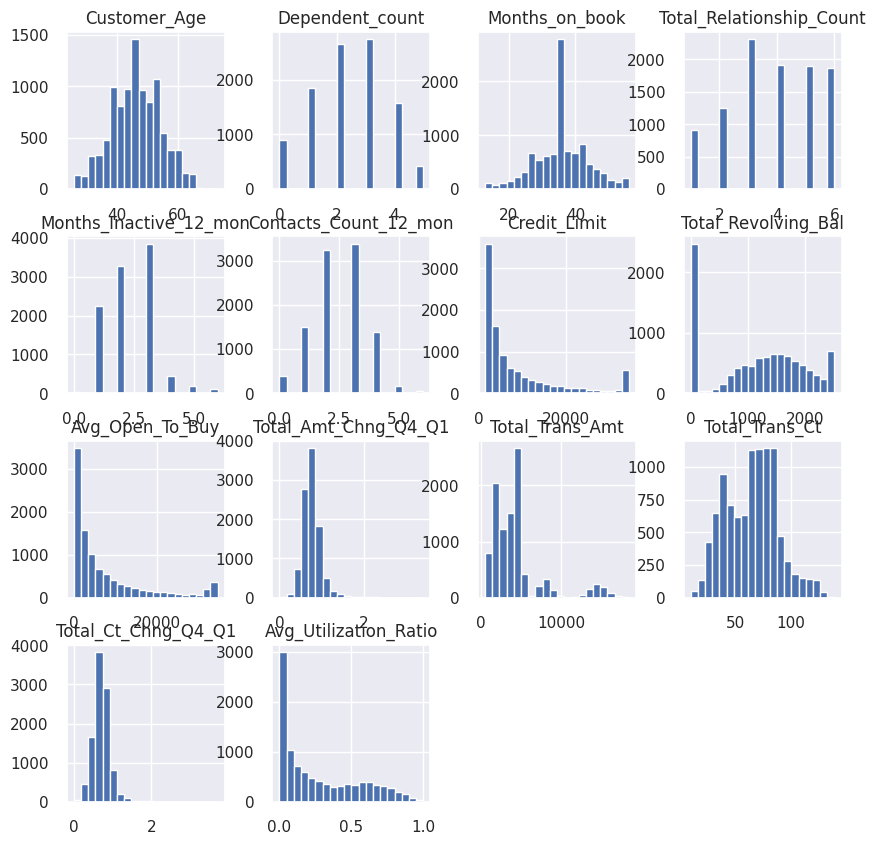

In [15]:
bank_data.loc[:,['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count','Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal','Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']].hist(bins=20, figsize=(10,10));

Aquí podemos ver donde oscilan estos valores.

In [20]:
bank_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,1,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,1,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Aquí podemos ver las diferentes correlaciones.

Cabe destacar que cuantos mas meses tienen contratados con el banco mas mayores son (los clientes lonjevos son mayores), el tamaño de las transacciones es inverso a la cantidad (o haces pocas muy grandes o muchas pequeas). La utilizacion esta inversamente relacionada con tu limite de credito y lo dispuesto que estas a comprar, mientras que esta directamente relacionada con el valor rotativo de la tarjeta. Finalmente, lo dispuesto que estas a comprar esta relacionado intimamente con el crédito.

In [21]:
bank_data['Attrition_Flag'] = bank_data['Attrition_Flag'].astype('category').cat.codes
bank_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,1,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,1,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


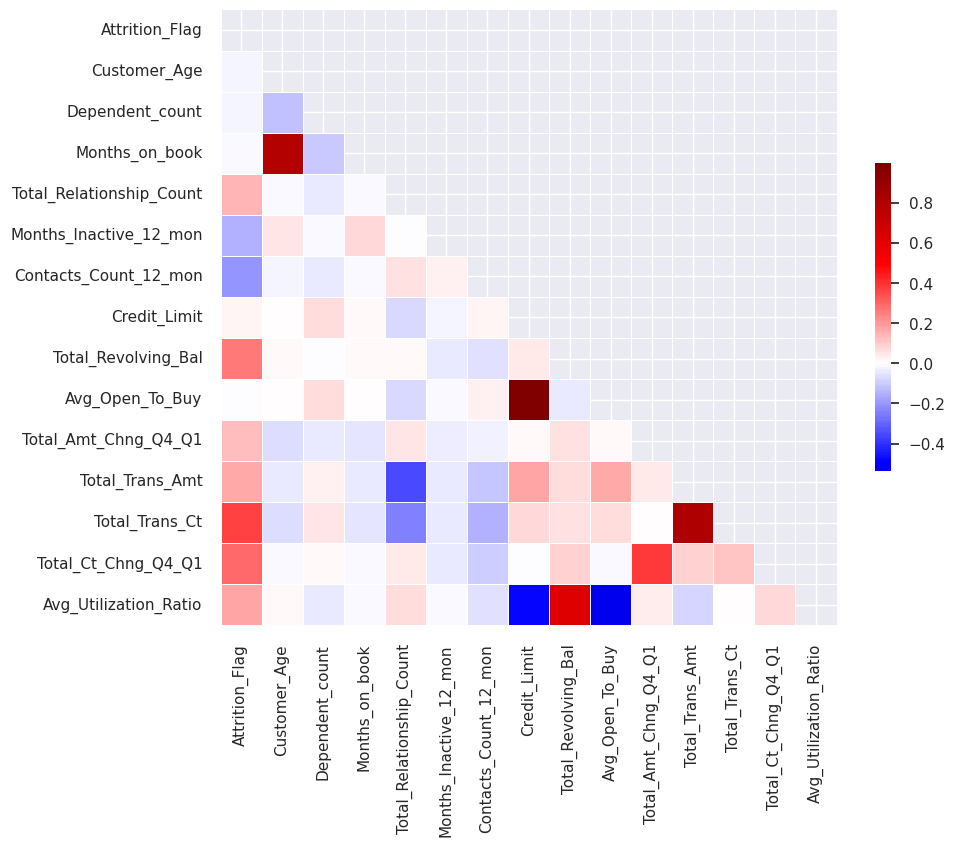

In [22]:
corr = bank_data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Con attrition flag vemos que esta directamente relacionado con cualquier valor que implique actividad dentro del banco (como se podria esperar). Y esta inversamente relacionado con la inactividad.

Las variables no son normales pero se acercan lo suficiente.

In [23]:
from scipy.stats import normaltest
print(normaltest(bank_data['Customer_Age'], nan_policy='omit'))
print(normaltest(bank_data['Dependent_count'], nan_policy='omit'))
print(normaltest(bank_data['Months_on_book'], nan_policy='omit'))

NormaltestResult(statistic=50.082604103279294, pvalue=1.3326027320307643e-11)
NormaltestResult(statistic=492.78112111526156, pvalue=9.861413207986435e-108)
NormaltestResult(statistic=66.92467470093706, pvalue=2.9342123257748353e-15)


Finalmente tenemos las variables categoricas las cuales son el genero, el tipo de trabajo, el estado civil y el tipo de tarjeta. A priori en los violins nos e ve nada muy interesante pero podremos aprofundizar más en como esas se relacionan con las demás cuando hagamos algo de preprocesado y podamos hacer un estudio de PCA.

De momeno vemos que los usuarios platino esan principalmente en hombres de entre 40 y 50, que el factor de huida no tiene mucho que ver con el genero, el nivel de educación sorprendentemente tampoco afecta mucho y tendremos que preprocesar algunos unknowns.

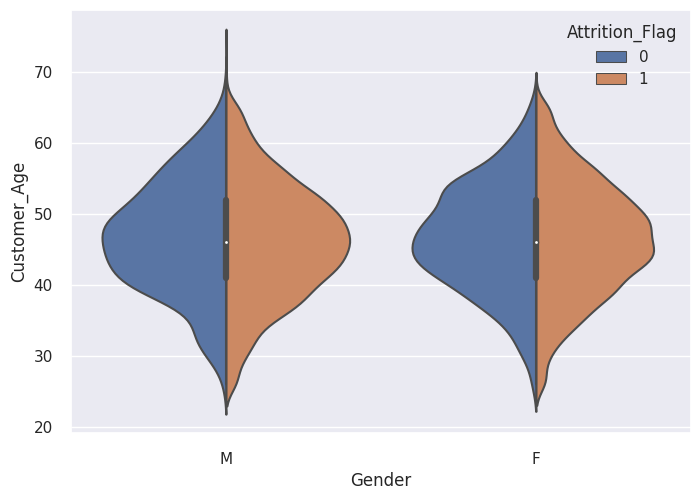

In [25]:
sns.violinplot(data=bank_data,x="Gender", y="Customer_Age", hue="Attrition_Flag", split=True);

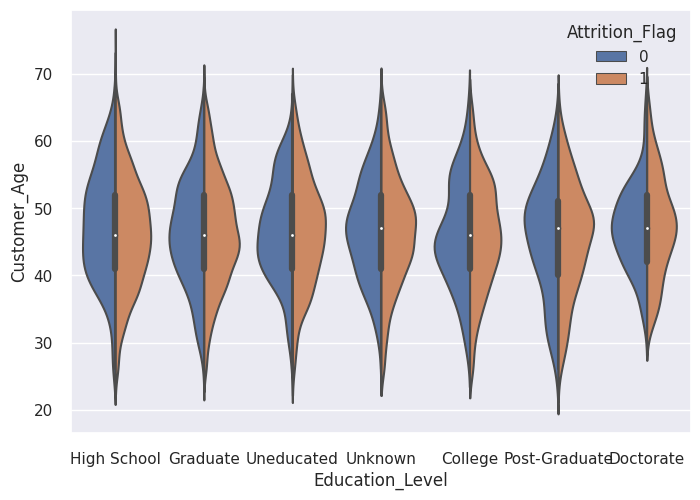

In [26]:
sns.violinplot(data=bank_data,x="Education_Level", y="Customer_Age", hue="Attrition_Flag", split=True);

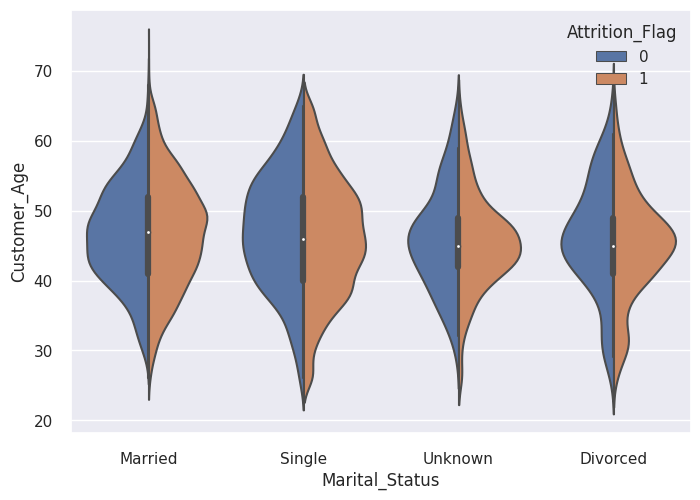

In [27]:
sns.violinplot(data=bank_data,x="Marital_Status", y="Customer_Age", hue="Attrition_Flag", split=True);

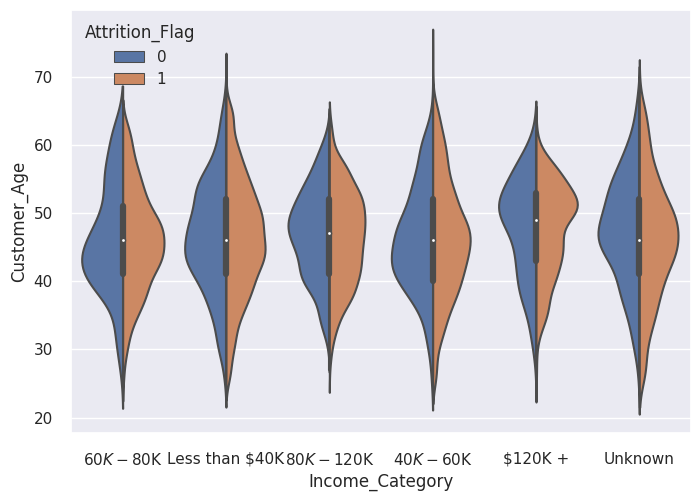

In [28]:
sns.violinplot(data=bank_data,x="Income_Category", y="Customer_Age", hue="Attrition_Flag", split=True);

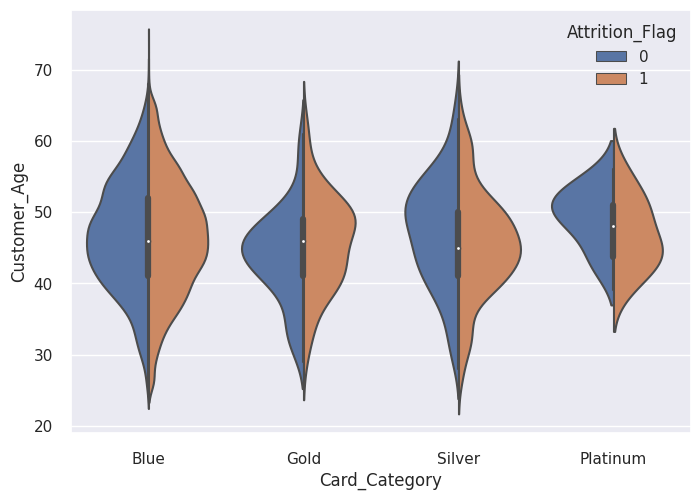

In [29]:
sns.violinplot(data=bank_data,x="Card_Category", y="Customer_Age", hue="Attrition_Flag", split=True);